# Boston House Price Model 

In [1]:
# !pip install -q --upgrade "matplotlib>=3.4" seaborn shap esparto==1.1.0.dev2 weasyprint > /dev/null

In [2]:
import datetime as dt
import getpass
import os
from datetime import datetime as dt
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib.ticker import EngFormatter

import esparto as es

%matplotlib inline

scatter_params = dict(
    marker=".",
    alpha=0.7
)

plt.style.use("seaborn-talk")
plt.style.use("seaborn-white")
plt.style.use("seaborn-paper")

figsize_default = (5.0, 3.0)
plt.rcParams['figure.figsize'] = figsize_default 
plt.rcParams['figure.dpi'] = 80

## Train Random Forest 

In [3]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

data = load_boston()
X = data["data"]
y = data["target"]
y = y * 1000
feature_names = data["feature_names"].tolist()
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_err = y_pred - y_test

y_pred = y_pred
y_actual = y_test

In [4]:
def format_ticks(fn):
    def wrapper(*args, **kwargs):
        ax = fn(*args, **kwargs)
        formatter = EngFormatter()
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        return ax
    return wrapper

In [5]:
@format_ticks
def plot_fit_vs_resid(y_pred, y_actual, ax):
    y_err = y_pred - y_actual

    ax.set_title("Residuals vs Fitted")
    ax.set_xlabel("Fitted Value")
    ax.set_ylabel("Residual")
    ax.scatter(y_pred, y_err, **scatter_params)
    ax.axhline(0, linewidth=1, c="k", ls=":")
    return ax

In [6]:
@format_ticks
def plot_pred_vs_actual(y_pred, y_actual, ax):
    ax.set_title("Predictions vs Actuals")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    ax.scatter(y_pred, y_actual, **scatter_params)
    ax.axline((0, 0), (1, 1), linewidth=2, c="C3", alpha=0.9, ls=":", label="ŷ=y")
    plt.legend()
    return ax

## Model Performance

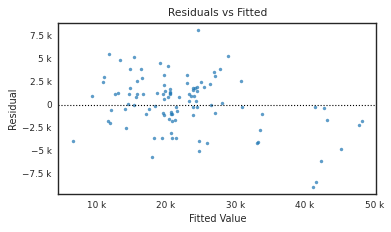

In [7]:
fit_vs_resid, ax = plt.subplots()
ax = plot_fit_vs_resid(y_pred, y_actual, ax=ax)
fit_vs_resid.tight_layout()

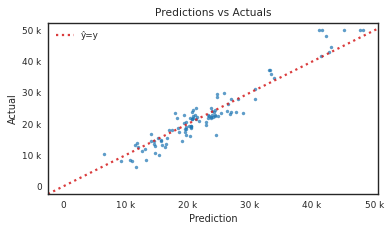

In [8]:
pred_vs_actual, ax = plt.subplots()
ax = plot_pred_vs_actual(y_pred, y_actual, ax)
pred_vs_actual.tight_layout()

In [9]:
overall_perf_plots = [fit_vs_resid, pred_vs_actual]

### Bootstrap CV Residuals

In [10]:
import math
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from functools import partial, update_wrapper
from collections import defaultdict

rms_error = partial(mean_squared_error, squared=False)
rms_error = update_wrapper(rms_error, mean_squared_error)

y_pred_cv = cross_val_predict(model, X, y, cv=5)
# cv_resids = y_pred_cv - y

y_actual = y
y_pred = y_pred_cv

idxs = np.arange(y_pred.shape[0])
bootstrap_samples = [np.random.choice(idxs, size=1000) for _ in range(1000)]

scorer_dict = {
    "R2": r2_score,
    "RMSE": rms_error,
    "MAE": mean_absolute_error,
}

scores = defaultdict(list)

for sample in bootstrap_samples:
    y_actual_tmp = y_actual[sample]
    y_pred_tmp = y_pred[sample]
    for name, fn in scorer_dict.items():
        scores[name].append(fn(y_actual_tmp, y_pred_tmp))

In [11]:
df = pd.DataFrame(scores)
df = df.rename(mapper=lambda x: x.replace("test_", ""), axis=1)
df = df[scorer_dict.keys()]
score_df = df
df = df.agg(["mean", "std"]).T
df["std"] *= 2
df = df.rename(columns={"std": "+/-"})
df.columns = ["Value", "95% CI"]
df.index.rename("Metric")
metrics_df = df
metrics_df

,Value,95% CI
R2,0.741734,0.048003
RMSE,4660.946834,500.541890
MAE,2996.874561,226.024424


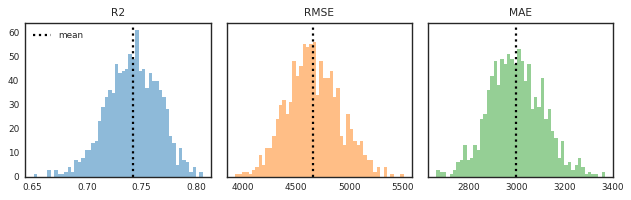

In [12]:
df = score_df
cv_score_dists, axes = plt.subplots(1, 3, figsize=[8, 2.6], sharey=True)
axes = np.ravel(axes)

for i, col in enumerate(score_df.columns):
    ax = axes[i]
    ax.set_title(col)
    ax.hist(df[col], color=f"C{i}", alpha=0.5, bins=50)
    ax.axvline(df[col].mean(), c="k", ls=":", lw=2, label="mean")
    if i == 0: ax.legend(loc="upper left")
cv_score_dists.tight_layout()

### Decile Performance

In [13]:
def plot_quantile_boxplot(array, quantiles=10):
    fig, ax = plt.subplots()
    qval = pd.qcut(array, 10, labels=list(range(1, 11)))
    decs = [array[qval == q] for q in sorted(qval.unique())]
    ax.boxplot(decs);
    return fig

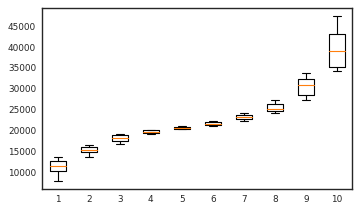

In [14]:
prediction_by_decile = plot_quantile_boxplot(y_pred);

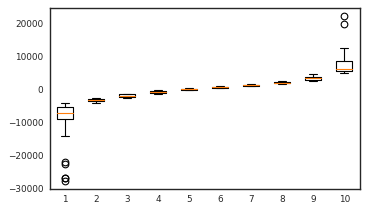

In [15]:
error_by_decile = plot_quantile_boxplot(y_pred - y_actual);

## Feature Importance

In [16]:
import shap

In [17]:
explainer = shap.Explainer(model, feature_names=feature_names)
shap_values = explainer(X_test)

In [18]:
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['Feature','Importance'])
feature_importance = feature_importance.sort_values(by=['Importance'], ascending=False)
feature_importance = feature_importance.set_index("Feature").round(2)
# feature_importance.index.name = ""
feature_importance.head()

,Importance
Feature,
LSTAT,4153.32
RM,2642.51
CRIM,433.60
DIS,432.29
NOX,419.18


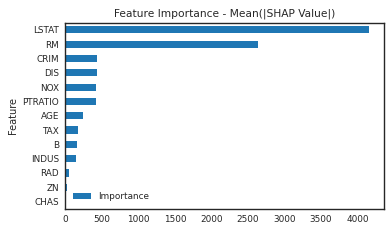

In [19]:
feature_importance.sort_values(by="Importance").plot.barh(title="Feature Importance - Mean(|SHAP Value|)")
feature_importance_plot = plt.gcf()
feature_importance_plot.tight_layout()

## Report Metadata

In [20]:
hparms = model.get_params()
hyperparm_df = pd.DataFrame.from_dict(hparms, orient="index")
hyperparm_df.columns = [""]

In [21]:
metadata_dict = {
    "Model": type(model).__name__,
    "Library": str(type(model)).split("'")[1].split(".")[0],
    "Version": sklearn.__version__,
    "Repository": "REPOSITORY-NAME",
    "Commit Hash": "COMMIT-HASH",
    "Developer": "Dominic Thorn",
    "Report Date": dt.now().strftime("%Y-%m-%d"),
}
report_metadata = pd.DataFrame.from_dict(metadata_dict, orient="index", columns=[""])

## Build Report

In [22]:
report_metadata

,
Model,RandomForestRegressor
Library,sklearn
Version,0.24.2
Repository,REPOSITORY-NAME
Commit Hash,COMMIT-HASH
Developer,Dominic Thorn
Report Date,2021-06-07


,
Model,RandomForestRegressor
Library,sklearn
Version,0.24.2
Repository,REPOSITORY-NAME
Commit Hash,COMMIT-HASH
Developer,Dominic Thorn
Report Date,2021-06-07
,
bootstrap,True
ccp_alpha,0

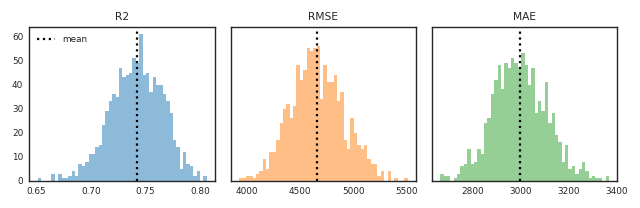
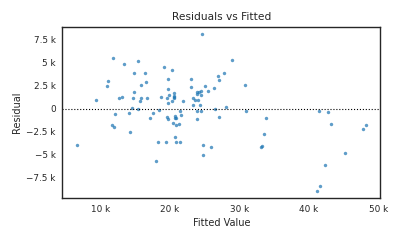
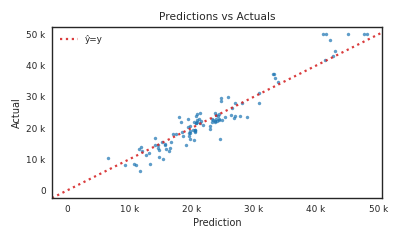
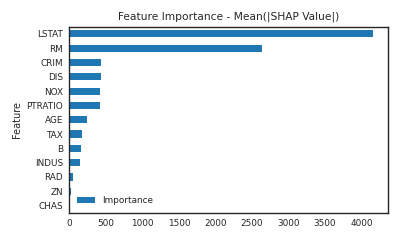

<IPython.core.display.Javascript object>

In [23]:
model_name = "Boston House Price Model"
page = es.Page(title=model_name)

page["Overview"]["Introduction"] = Path("introduction.md").read_text()
page["Overview"][""]["Metadata"] = report_metadata
page["Overview"][-1]["Hyperparameters"] = hyperparm_df
page += es.PageBreak()

page["Performance"][""] = metrics_df.round(2), es.Spacer()
page["Performance"]["Bootstrap CV Score Distributions"] = cv_score_dists
page["Performance"]["Diagnostics"] = overall_perf_plots
page += es.PageBreak()

page["Feature Analysis"][""] = feature_importance_plot
page["Feature Analysis"][""] = feature_importance

page.display()
page.save_html("boston-house-price-model.html")
page.save_pdf("boston-house-price-model.pdf")

## TODO
  * Subset performance
  * Partial dependency plots